In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('Bank.csv')

In [3]:
data.drop(data[['day', 'month' ]],axis = 1, inplace = True)

In [4]:
data = pd.get_dummies(data, drop_first = True)

In [5]:
data.columns

Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes',
       'loan_yes', 'contact_telephone', 'contact_unknown', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown', 'y_yes'],
      dtype='object')

In [6]:
# Self-organizing map

X = data.iloc[:, : -1].values
y = data.iloc[:, -1].values

In [7]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

In [8]:
from minisom import MiniSom

som = MiniSom(x = 10, y = 10, input_len = 30, sigma = 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

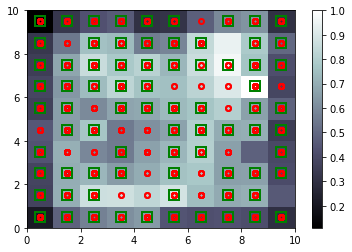

In [9]:
#from pylab import bone, pcolor, colorbar, plot, show

plt.bone()
plt.pcolor(som.distance_map().T)
plt.colorbar()
markers = ['.', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plt.plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)

In [10]:
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(6,5)], mappings[(6,5)], mappings[(8,8)]), axis = 0)
frauds = sc.inverse_transform(frauds)

In [11]:
fraud = pd.DataFrame(frauds, columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes',
       'loan_yes', 'contact_telephone', 'contact_unknown', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'])
fraud = fraud.astype('int32')
fraud.head()

,age,balance,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,56,1906,45,9,-1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
1,57,5799,96,1,-1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,59,1033,1199,1,-1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
3,55,8894,262,1,-1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,54,3670,67,3,-1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [12]:
# Predecting outcome with a classification ANN

X = data.iloc[:, : -1].values
y = data.iloc[:, -1].values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from numpy.random import seed

Using TensorFlow backend.


In [15]:
def my_model():
    seed(42)
    tf.random.set_seed(42)
    
    model = Sequential()
    
    model.add(Dense(units = 30, activation = 'relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(units = 1, activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10)
model = my_model()

In [16]:
training = model.fit(X_train, y_train, epochs = 100, batch_size = 64, verbose = 1, validation_data = (X_test, y_test), shuffle = True, callbacks = [es])

Train on 3029 samples, validate on 1492 samples
Epoch 1/100
3029/3029 [==============================] - 5s 2ms/step - loss: 0.4891 - accuracy: 0.7900 - val_loss: 0.3272 - val_accuracy: 0.8941
Epoch 2/100
3029/3029 [==============================] - 0s 157us/step - loss: 0.3648 - accuracy: 0.8802 - val_loss: 0.3138 - val_accuracy: 0.8941
Epoch 3/100
3029/3029 [==============================] - 1s 367us/step - loss: 0.3489 - accuracy: 0.8802 - val_loss: 0.3035 - val_accuracy: 0.8941
Epoch 4/100
3029/3029 [==============================] - 1s 272us/step - loss: 0.3335 - accuracy: 0.8802 - val_loss: 0.3018 - val_accuracy: 0.8941
Epoch 5/100
3029/3029 [==============================] - 0s 150us/step - loss: 0.3347 - accuracy: 0.8802 - val_loss: 0.2911 - val_accuracy: 0.8941
Epoch 6/100
3029/3029 [==============================] - 1s 180us/step - loss: 0.3262 - accuracy: 0.8802 - val_loss: 0.2863 - val_accuracy: 0.8941
Epoch 7/100
3029/3029 [==============================] - 0s 152us/step -

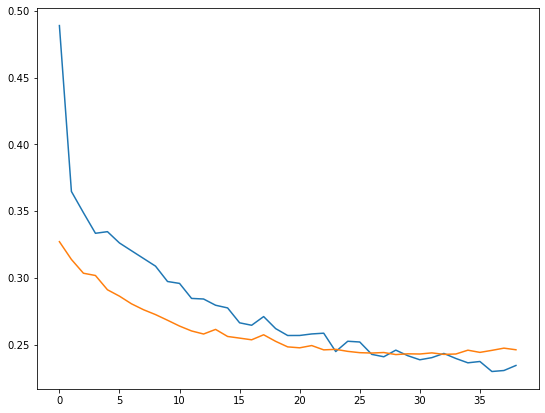

In [17]:
plt.figure(figsize = (9,7))
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])

In [18]:
prediction = model.predict_classes(X_test)
#prediction = prediction > 0.5

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, prediction))

print(classification_report(y_test, prediction))

[[1278   56]
 [  95   63]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1334
           1       0.53      0.40      0.45       158

    accuracy                           0.90      1492
   macro avg       0.73      0.68      0.70      1492
weighted avg       0.89      0.90      0.89      1492



In [20]:
score = model.evaluate(X_test, y_test)

1492/1492 [==============================] - 0s 36us/step


In [21]:
print('Loss: ', score[0])
print('Accuracy: ', score[1])

Loss:  0.24616170790415987
Accuracy:  0.8987935781478882


In [50]:
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn = my_model, verbose = 1)

batch_size = [16, 32, 64]
epochs = [100, 200]
param_grid = dict(batch_size = batch_size, epochs = epochs)

grid = GridSearchCV(estimator = model, 
                    param_grid = param_grid,
                    cv = 3,
                    verbose = 2, n_jobs = -1)

grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  7.6min finished


In [51]:
grid_result

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000000001365C448>,
             iid='warn', n_jobs=-1,
             param_grid={'batch_size': [16, 32, 64], 'epochs': [100, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [52]:
grid.best_params_

{'batch_size': 64, 'epochs': 100}